<a href="https://colab.research.google.com/github/rtnaka/ai-quest2021_assessment/blob/main/PBL01_sample_code_%E6%94%B9%E5%A4%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import library

In [1]:
!pip install japanize-matplotlib
!pip install category_encoders

In [2]:
from itertools import product
from datetime import datetime

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import japanize_matplotlib 

import category_encoders as ce

from lightgbm import LGBMRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# read data

In [3]:
# Google DriveをColabにマウント
from google.colab import drive
drive.mount('/content/drive')

#　filepath
basepath = '/content/drive/MyDrive/AI Quest2021/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
sales = pd.read_csv(basepath+'sales_history.csv',parse_dates=["日付"])
cats = pd.read_csv(basepath+'item_categories.csv')
cat_names = pd.read_csv(basepath+'category_names.csv')
test = pd.read_csv(basepath+'test.csv',index_col=0)
sub = pd.read_csv(basepath+'sample_submission.csv', header=None)

In [5]:
#最大表示行数指定
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)

# Preprocess

### merge table

In [6]:
#category_names 　→　大カテゴリ/小カテゴリに分割
split_catname = cat_names["商品カテゴリ名"].str.split("-",expand=True)
cat_names = pd.concat([cat_names,split_catname],axis=1)
cat_names.drop("商品カテゴリ名",axis=1,inplace=True)
cat_names.rename(columns={0: '商品大カテゴリ', 1: '商品小カテゴリ'},inplace=True)
cat_names.head()

,商品カテゴリID,商品大カテゴリ,商品小カテゴリ
0,100,映画,DVD
1,110,PCゲーム,通常版
2,120,音楽,その他
3,130,ゲーム,ゲーム機C
4,140,映画,ブルーレイ


In [7]:
#「sales_history.csv」、「item_category.csv」、「category_names.csv」の3つのテーブルを統合
sales = pd.merge(sales, cats, on='商品ID', how='left')
sales = pd.merge(sales, cat_names, on='商品カテゴリID', how='left')
sales.head()

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ
0,2018-01-01,9,1000001,420,1.0,100,映画,DVD
1,2018-01-01,6,1000001,420,1.0,100,映画,DVD
2,2018-01-01,10,1000001,420,1.0,100,映画,DVD
3,2018-01-01,0,1000017,250,1.0,100,映画,DVD
4,2018-01-01,1,1000017,250,1.0,100,映画,DVD


### add columns

In [8]:
# 日付列から年と月を抽出し、新たな列とする
sales['年'] = sales['日付'].dt.year
sales['月'] = sales['日付'].dt.month
sales['四半期'] = sales['日付'].dt.quarter

In [9]:
# 「年」と「月」の全組み合わせを作成する
gp_time = sales.groupby(['年','月','四半期']).count().reset_index()[['年', '月','四半期']]
# カラム名「月ブロック」として、通し番号をつける
gp_time['月ブロック'] = list(range(len(gp_time)))

# 2019年12月(月ブロック: 23)のレコードを追加する
gp_time = gp_time.append({
    '月ブロック': 23,
    '年': 2019,
    '月': 12,
    '四半期':4
}, ignore_index=True)

In [10]:
# 「月ブロック」カラムをsalesに統合する
sales = pd.merge(sales, gp_time, on=['年', '月','四半期'], how='left')

In [11]:
#売上金額を追加
sales["売上金額"] = sales.商品価格 * sales.売上個数

In [12]:
#商品価格をbiningし、価格帯として列作成
price_bin = pd.DataFrame(pd.cut(sales.商品価格, [0, 300,500,750,1000,2000,3000,10000],labels=False))
price_bin.columns = ["価格帯"]
sales = pd.concat([sales,price_bin],axis=1)

In [13]:
sales.head()

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ,年,月,四半期,月ブロック,売上金額,価格帯
0,2018-01-01,9,1000001,420,1.0,100,映画,DVD,2018,1,1,0,420.0,1.0
1,2018-01-01,6,1000001,420,1.0,100,映画,DVD,2018,1,1,0,420.0,1.0
2,2018-01-01,10,1000001,420,1.0,100,映画,DVD,2018,1,1,0,420.0,1.0
3,2018-01-01,0,1000017,250,1.0,100,映画,DVD,2018,1,1,0,250.0,0.0
4,2018-01-01,1,1000017,250,1.0,100,映画,DVD,2018,1,1,0,250.0,0.0


### extract 

In [14]:
#需要予測対象の170商品の抜き出し
product_id = test["商品ID"].unique()

sales_all = sales.copy()
sales = sales[sales["商品ID"].isin(product_id)]

In [15]:
sales.商品ID.nunique()

170

# EDA

In [16]:
# 2018年に販売実績のある商品数
items_2018 = sales[sales["日付"] < datetime(2019, 1, 1)]["商品ID"].unique()
# 2019年に販売実績のある商品数
items_2019 = sales[sales["日付"] > datetime(2018, 12, 31)]["商品ID"].unique()
# 2019年4月以降に販売実績のある商品数
items_2019_04 = sales[sales["日付"] > datetime(2019, 3, 31)]["商品ID"].unique()
# 2019年7月以降に販売実績のある商品数
items_2019_07 = sales[sales["日付"] > datetime(2019, 6, 30)]["商品ID"].unique()
# 2019年10月以降に販売実績のある商品数
items_2019_10 = sales[sales["日付"] > datetime(2019, 9, 30)]["商品ID"].unique()
#2018年１２月に販売実績のあった商品数
items_201812 = sales[(sales["日付"] > datetime(2018, 11, 30))&(sales["日付"] < datetime(2019, 1, 1))]["商品ID"].unique()
#2019年10月に販売実績のない商品ID
items_201910_notSales =  np.setdiff1d(items_2019_07, items_2019_10)
#2019年から販売開始された　or ２０１８年は実績がなかった商品
items_2019only = np.setdiff1d(items_2019, items_2018)

print("2018年販売実績あり：",len(items_2018))
print("2019年販売実績あり：",len(items_2019))
print("2019年4月以降販売実績あり：",len(items_2019_04))
print("2019年7月以降販売実績あり：",len(items_2019_07))
print("2019年10月以降販売実績あり：",len(items_2019_10))
print("2018年12月に販売実績あり：",len(items_201812))
print("2019年10月に販売実績のない商品ID",items_201910_notSales)
print("２０１８年販売実績無し",items_2019only)

2018年販売実績あり： 150
2019年販売実績あり： 170
2019年4月以降販売実績あり： 170
2019年7月以降販売実績あり： 170
2019年10月以降販売実績あり： 168
2018年12月に販売実績あり： 150
2019年10月に販売実績のない商品ID [1700013 3000001]
２０１８年販売実績無し [1002291 1002377 1002503 1002582 1201262 1201269 1400898 1600052 1600054
 1800179 2000162 2100152 2400088 2500229 2500230 2800090 2800101 2800103
 2900075 3200026]


In [17]:
pd.options.display.float_format = '{:.2f}'.format
sales.describe(percentiles=[0.9,0.99,0.999,0.9999])

,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,年,月,四半期,月ブロック,売上金額,価格帯
count,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00
mean,8.07,1815224.63,1048.98,1.05,181.51,2018.51,6.28,2.43,11.35,1101.62,2.62
std,4.96,674604.62,958.35,0.38,67.47,0.50,3.45,1.12,6.09,1171.45,1.73
min,0.00,1000001.00,60.00,-2.00,100.00,2018.00,1.00,1.00,0.00,-3400.00,0.00
50%,8.00,1700001.00,590.00,1.00,170.00,2019.00,6.00,2.00,12.00,590.00,2.00
90%,15.00,2800001.00,2450.00,1.00,280.00,2019.00,11.00,4.00,19.00,2550.00,5.00
99%,17.00,3400003.00,5100.00,2.00,340.00,2019.00,12.00,4.00,21.00,5100.00,6.00
99.9%,17.00,3500001.00,6460.00,5.00,350.00,2019.00,12.00,4.00,21.00,10200.00,6.00
99.99%,17.00,3500001.00,6460.00,14.00,350.00,2019.00,12.00,4.00,21.00,17115.60,6.00
max,17.00,3500001.00,6460.00,24.00,350.00,2019.00,12.00,4.00,21.00,71400.00,6.00


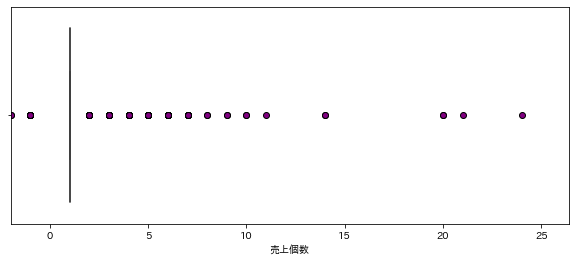

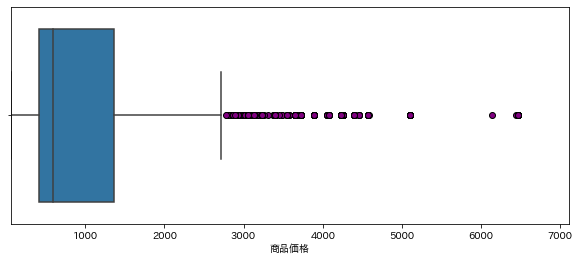

In [18]:
plt.figure(figsize=(10,4))
plt.xlim(sales.売上個数.min(), sales.売上個数.max()*1.1)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=sales.売上個数, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(sales.商品価格.min(), sales.商品価格.max()*1.1)
sns.boxplot(x=sales.商品価格, flierprops=flierprops)

# Create Dataset

### テーブル変換

In [19]:
def crate_monthly_table (df_sales):
  gp_month = df_sales.groupby(['月ブロック', '商品ID', '店舗ID']).agg({'売上個数': np.sum}).reset_index()
  yyyymm =  np.sort(df_sales.月ブロック.unique())
  all_combination = []
  columns = ['月ブロック', '商品ID', '店舗ID']

  #商品ID×店舗IDの直積
  for i in yyyymm:
    all_combination.append(list(product([i], df_sales.商品ID.unique(), df_sales.店舗ID.unique())))
  
  all_combination = pd.DataFrame(np.vstack(np.array(all_combination)), columns=columns)
  all_combination.sort_values(columns, inplace=True)

  # all_combinationにsalesテーブルを統合
  all_train = pd.merge(all_combination, gp_month, on=['月ブロック', '商品ID', '店舗ID'], how='left')
  # all_train['売上個数'] = all_train['売上個数'].fillna(0)

  return all_train

In [20]:
train = crate_monthly_table(sales)

In [21]:
train.describe(percentiles=[0.9,0.99,0.999,0.9999])

,月ブロック,商品ID,店舗ID,売上個数
count,67320.00,67320.00,67320.00,25407.00
mean,10.50,1868329.94,8.50,1.99
std,6.34,684659.75,5.19,2.36
min,0.00,1000001.00,0.00,-1.00
50%,10.50,1700013.50,8.50,1.00
90%,19.00,2800009.90,16.00,4.00
99%,21.00,3400003.00,17.00,10.00
99.9%,21.00,3500001.00,17.00,30.00
99.99%,21.00,3500001.00,17.00,64.46
max,21.00,3500001.00,17.00,88.00


In [22]:
train.isnull().sum()

月ブロック        0
商品ID         0
店舗ID         0
売上個数     41913
dtype: int64

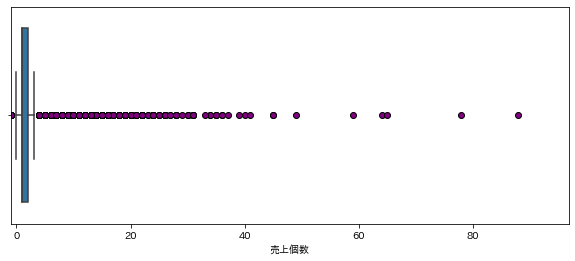

In [23]:
plt.figure(figsize=(10,4))
plt.xlim(train.売上個数.min(), train.売上個数.max()*1.1)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.売上個数, flierprops=flierprops)

### train/testのデータ結合

In [24]:
def merge_train_test (df_train,df_test):
  df_test['月ブロック'] = 23
  dataset = pd.concat([df_train, df_test])

  return dataset

In [25]:
dataset = merge_train_test (train,test)
dataset.head()

,月ブロック,商品ID,店舗ID,売上個数
0,0,1000001,0,6.00
1,0,1000001,1,2.00
2,0,1000001,2,1.00
3,0,1000001,3,2.00
4,0,1000001,4,nan


# Feature Engneering

### 商品カテゴリ・時間情報の結合

In [26]:
def merge_category_columns(dataset,cats,cat_names,gp_time): 
  dataset = pd.merge(dataset, cats, on='商品ID', how='left')
  dataset = pd.merge(dataset, cat_names, on='商品カテゴリID', how='left')
  dataset = pd.merge(dataset, gp_time, on='月ブロック', how='left')

  return dataset

In [27]:
dataset = merge_category_columns(dataset,cats,cat_names,gp_time)
dataset.head()

,月ブロック,商品ID,店舗ID,売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ,年,月,四半期
0,0,1000001,0,6.00,100,映画,DVD,2018,1,1
1,0,1000001,1,2.00,100,映画,DVD,2018,1,1
2,0,1000001,2,1.00,100,映画,DVD,2018,1,1
3,0,1000001,3,2.00,100,映画,DVD,2018,1,1
4,0,1000001,4,nan,100,映画,DVD,2018,1,1


### 集約テーブル作成

In [28]:
#売上個数がマイナス＝返品と捉え、商品ID毎の返品数のテーブルを作成
returns = pd.DataFrame(sales[sales.売上個数 < 0].商品カテゴリID.value_counts()).reset_index()
returns.columns = ["商品カテゴリID","返品回数"]
returns

,商品カテゴリID,返品回数
0,120,21
1,260,9
2,280,6
3,100,5
4,210,5
5,240,4
6,110,4
7,340,4
8,320,3
9,230,3


In [29]:
#売上レコードが始めて現れた月　売上レコードなしの組み合わせは-1
sales_start_month = sales.groupby(["店舗ID","商品ID"])["月ブロック"].agg(販売開始月ブロック = "min").unstack(fill_value=-1).stack()
sales_start_month = pd.DataFrame(sales_start_month).reset_index()
sales_start_month.head()

,店舗ID,商品ID,販売開始月ブロック
0,0,1000001,0
1,0,1000002,0
2,0,1000003,1
3,0,1000004,0
4,0,1000005,0


In [30]:
#売上レコードが始めて現れた月　商品毎
sales_start_month_p = sales.groupby(["商品ID"])["月ブロック"].agg(販売開始月ブロック_pid = "min").reset_index()
sales_start_month_p.head()

,商品ID,販売開始月ブロック_pid
0,1000001,0
1,1000002,0
2,1000003,0
3,1000004,0
4,1000005,0


In [31]:
#商品ID毎に定価（価格の最大値、セール価格（min)、平均と中央を算出
#pid = product ID
agg_productID_price = sales.groupby(['商品ID'])["商品価格"].agg(定価_pid="max",セール価格_pid="min",平均価格_pid="mean",中央値価格_pid="median").reset_index()
price_bin = pd.DataFrame(pd.cut(agg_productID_price.定価_pid, [0, 300,500,750,1000,2000,3000,10000],labels=False))
price_bin.columns = ["価格帯"]
agg_productID_price = pd.concat([agg_productID_price,price_bin],axis=1)
agg_productID_price.head()

,商品ID,定価_pid,セール価格_pid,平均価格_pid,中央値価格_pid,価格帯
0,1000001,420,120,367.81,420,1
1,1000002,250,100,236.97,250,0
2,1000003,250,120,228.66,250,0
3,1000004,250,120,224.03,250,0
4,1000005,250,90,245.25,250,0


In [32]:
#商品カテゴリID毎に定価（価格の最大値、セール価格（min)、平均と中央を算出
#cid = categoryID
agg_catID_price = sales.groupby(['商品カテゴリID'])["商品価格"].agg(最大価格_cid="max",最小価格_cid="min",平均価格_cid="mean",中央値価格_cid="median").reset_index()
agg_catID_price.head()

,商品カテゴリID,最大価格_cid,最小価格_cid,平均価格_cid,中央値価格_cid
0,100,680,90,348.36,250
1,110,590,60,191.16,170
2,120,3650,120,463.38,510
3,130,4250,760,1633.78,1530
4,140,1360,80,656.83,630


In [33]:
#商品大カテゴリID毎に定価（価格の最大値、セール価格（min)、平均と中央を算出
# lc = Large Category
agg_LargeCat_price = sales.groupby(['商品大カテゴリ'])["商品価格"].agg(最大価格_lc="max",最小価格_lc="min",平均価格_lc="mean",中央値価格_lc="median").reset_index()
agg_LargeCat_price.head()

,商品大カテゴリ,最大価格_lc,最小価格_lc,平均価格_lc,中央値価格_lc
0,PCゲーム,590,60,191.16,170
1,PCソフト,2870,1240,2423.83,2020
2,ギフト,5100,100,1465.86,1190
3,ゲーム,4250,760,1751.43,1700
4,ゲーム周辺機器,4570,330,1409.42,1190


In [34]:
dataset = pd.merge(dataset, returns, on='商品カテゴリID', how='left')
dataset = pd.merge(dataset, sales_start_month, on=["店舗ID","商品ID"], how='left')
dataset = pd.merge(dataset, sales_start_month_p, on='商品ID', how='left')
dataset = pd.merge(dataset, agg_productID_price, on='商品ID', how='left')
dataset = pd.merge(dataset, agg_catID_price, on='商品カテゴリID', how='left')
dataset = pd.merge(dataset, agg_LargeCat_price, on='商品大カテゴリ', how='left')

In [35]:
dataset.head()

,月ブロック,商品ID,店舗ID,売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ,年,月,四半期,返品回数,販売開始月ブロック,販売開始月ブロック_pid,定価_pid,セール価格_pid,平均価格_pid,中央値価格_pid,価格帯,最大価格_cid,最小価格_cid,平均価格_cid,中央値価格_cid,最大価格_lc,最小価格_lc,平均価格_lc,中央値価格_lc
0,0,1000001,0,6.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420
1,0,1000001,1,2.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420
2,0,1000001,2,1.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420
3,0,1000001,3,2.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420
4,0,1000001,4,nan,100,映画,DVD,2018,1,1,5.00,1,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420


### 販売実績　0 or 販売実績 null

In [36]:
dataset["未販売"] = (dataset["月ブロック"] <  dataset["販売開始月ブロック_pid"]).astype(int)
dataset.head()

,月ブロック,商品ID,店舗ID,売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ,年,月,四半期,返品回数,販売開始月ブロック,販売開始月ブロック_pid,定価_pid,セール価格_pid,平均価格_pid,中央値価格_pid,価格帯,最大価格_cid,最小価格_cid,平均価格_cid,中央値価格_cid,最大価格_lc,最小価格_lc,平均価格_lc,中央値価格_lc,未販売
0,0,1000001,0,6.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0
1,0,1000001,1,2.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0
2,0,1000001,2,1.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0
3,0,1000001,3,2.00,100,映画,DVD,2018,1,1,5.00,0,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0
4,0,1000001,4,nan,100,映画,DVD,2018,1,1,5.00,1,0,420,120,367.81,420,1,680,90,348.36,250,6460,80,1033.66,420,0


In [37]:
dataset.未販売.value_counts()

0    60462
1     9918
Name: 未販売, dtype: int64

In [38]:
dataset  = dataset[dataset.未販売 == 0]

In [39]:
dataset["売上個数"].fillna(0,inplace=True)

In [40]:
dataset.isnull().sum()

月ブロック               0
商品ID                0
店舗ID                0
売上個数                0
商品カテゴリID            0
商品大カテゴリ             0
商品小カテゴリ             0
年                   0
月                   0
四半期                 0
返品回数             3690
販売開始月ブロック           0
販売開始月ブロック_pid       0
定価_pid              0
セール価格_pid           0
平均価格_pid            0
中央値価格_pid           0
価格帯                 0
最大価格_cid            0
最小価格_cid            0
平均価格_cid            0
中央値価格_cid           0
最大価格_lc             0
最小価格_lc             0
平均価格_lc             0
中央値価格_lc            0
未販売                 0
dtype: int64

### 月毎の日数を追加、特定キーワードを含むカテゴリ列か判定する列を追加

In [41]:
days_of_month = pd.DataFrame({'月': range(1,13),'日数': [31,28,31,30,31,30,31,31,30,31,30,31]})
dataset = pd.merge(dataset, days_of_month, on='月', how='left')

In [42]:
col = "商品小カテゴリ"
new_col = "ゲーム"
dataset[new_col] = dataset[col].str.contains(new_col).astype(int)

new_col = "記念品"
dataset[new_col] = dataset[col].str.contains(new_col).astype(int)

In [43]:
dataset["割引率"] = dataset["セール価格_pid"]/dataset["定価_pid"]

In [44]:
dataset["売上金額"] = dataset["売上個数"] * dataset["定価_pid"]

In [45]:
dataset["返品回数"].fillna(0,inplace=True)

In [46]:
dataset.isnull().sum()

月ブロック            0
商品ID             0
店舗ID             0
売上個数             0
商品カテゴリID         0
商品大カテゴリ          0
商品小カテゴリ          0
年                0
月                0
四半期              0
返品回数             0
販売開始月ブロック        0
販売開始月ブロック_pid    0
定価_pid           0
セール価格_pid        0
平均価格_pid         0
中央値価格_pid        0
価格帯              0
最大価格_cid         0
最小価格_cid         0
平均価格_cid         0
中央値価格_cid        0
最大価格_lc          0
最小価格_lc          0
平均価格_lc          0
中央値価格_lc         0
未販売              0
日数               0
ゲーム              0
記念品              0
割引率              0
売上金額             0
dtype: int64

### ラグ特徴量の作成

In [47]:
def create_lag_feature(df_sales,dataset,month,agg_name,agg_cols):
  gp_month_count = df_sales.groupby(agg_cols).agg({'売上個数': "count"}).reset_index()
  gp_month_sum = df_sales.groupby(agg_cols).agg({'売上個数': np.sum}).reset_index()
  gp_month_mean = df_sales.groupby(agg_cols).agg({'売上個数': np.mean}).reset_index()
  gp_month_max = df_sales.groupby(agg_cols).agg({'売上個数': np.max}).reset_index()

  gp_month_list = [gp_month_count,gp_month_sum,gp_month_mean,gp_month_max]
  gp_month_names = ["count","sum","mean","max"]


  for gp_month,gp_month_name in zip(gp_month_list,gp_month_names):
    for i in range(2,month):
      lag = gp_month.copy()   
      lag['月ブロック'] = lag['月ブロック'] + i

      change_col_name = str(i)+'m_('+agg_name+')売上数_'+gp_month_name
      lag = lag.rename(columns={'売上個数': change_col_name})

      dataset = pd.merge(dataset, lag, on= agg_cols, how='left', left_index=True)
      dataset[change_col_name].fillna(0,inplace=True)
  return dataset

In [48]:
month = 7
agg_names = ["個別","商品別","店舗別","カテゴリID別","大カテゴリ別","価格帯別"]
agg_cols_list = [['月ブロック', '商品ID','店舗ID'],['月ブロック', '商品ID'],['月ブロック', '店舗ID'],['月ブロック','商品カテゴリID'],['月ブロック', '商品大カテゴリ'],['月ブロック','価格帯']]

for agg_name,agg_cols in zip(agg_names,agg_cols_list):
  dataset = create_lag_feature(sales,dataset,month,agg_name,agg_cols)

### 移動統計量の作成

In [49]:
def create_rolling_feature(dataset,cols_target,col_name_prefix): 
  
  cols_3m = cols_target[:2]
  cols_4m = cols_target[:3]
  cols_5m = cols_target[:4]
  cols_6m = cols_target[:5]
  cols_7m = cols_target[:6]
  cols_8m = cols_target[:7]
  cols_9m = cols_target[:8]
  cols_10m = cols_target[:9]
  cols_11m = cols_target[:10]
  cols_12m = cols_target

  #cols_list = [cols_3m,cols_4m,cols_5m,cols_6m,cols_7m,cols_8m,cols_9m,cols_10m,cols_11m,cols_12m]
  #cols_list = [cols_3m,cols_6m,cols_9m,cols_10m,cols_12m]
  cols_list = [cols_3m,cols_4m,cols_5m,cols_6m]

  # agg_num = [3,4,5,6,7,8,9,10,11,12]
  agg_num = [3,4,5,6]
  #agg_num = [3,6,9,10,12]


  for num,cols in zip(agg_num,cols_list): 
    col_name = '売上個数({})_agg{}m_sum'.format( col_name_prefix, num )
    dataset[col_name] = dataset[cols].sum(axis=1)

    col_name = '売上個数({})_agg{}m_max'.format( col_name_prefix, num )
    dataset[col_name] = dataset[cols].max(axis=1)

    col_name = '売上個数({})_agg{}m_mean'.format(col_name_prefix,  num )
    dataset[col_name] = dataset[cols].mean(axis=1)

  return dataset

In [50]:
cols = list(dataset.columns)

cols_combi = [col for col in cols if '(個別)売上数_sum' in col]
cols_product = [col for col in cols if '(商品別)売上数_sum' in col]
cols_store = [col for col in cols if '(店舗別)売上数_sum' in col]
cols_catID = [col for col in cols if '(カテゴリID別)売上数_sum' in col]
cols_catL = [col for col in cols if '(大カテゴリ別)売上数_sum' in col]
cols_priceBin = [col for col in cols if '(価格帯別)売上数_sum' in col]

cols_target_list = [cols_combi,cols_product,cols_store,cols_catID,cols_catL,cols_priceBin]
col_name_prefix_list = ["個別","商品別","店舗別","カテゴリID別","大カテゴリ別","価格帯別"]

for cols_target ,col_name_prefix in zip(cols_target_list,col_name_prefix_list):
  dataset = create_rolling_feature(dataset , cols_target, col_name_prefix)
  

### translate data type

In [51]:
dataset.describe()

,月ブロック,商品ID,店舗ID,売上個数,商品カテゴリID,年,月,四半期,返品回数,販売開始月ブロック,販売開始月ブロック_pid,定価_pid,セール価格_pid,平均価格_pid,中央値価格_pid,価格帯,最大価格_cid,最小価格_cid,平均価格_cid,中央値価格_cid,最大価格_lc,最小価格_lc,平均価格_lc,中央値価格_lc,未販売,日数,ゲーム,記念品,割引率,売上金額,2m_(個別)売上数_count,3m_(個別)売上数_count,4m_(個別)売上数_count,5m_(個別)売上数_count,6m_(個別)売上数_count,2m_(個別)売上数_sum,3m_(個別)売上数_sum,4m_(個別)売上数_sum,5m_(個別)売上数_sum,6m_(個別)売上数_sum,2m_(個別)売上数_mean,3m_(個別)売上数_mean,4m_(個別)売上数_mean,5m_(個別)売上数_mean,6m_(個別)売上数_mean,2m_(個別)売上数_max,3m_(個別)売上数_max,4m_(個別)売上数_max,5m_(個別)売上数_max,6m_(個別)売上数_max,2m_(商品別)売上数_count,3m_(商品別)売上数_count,4m_(商品別)売上数_count,5m_(商品別)売上数_count,6m_(商品別)売上数_count,2m_(商品別)売上数_sum,3m_(商品別)売上数_sum,4m_(商品別)売上数_sum,5m_(商品別)売上数_sum,6m_(商品別)売上数_sum,2m_(商品別)売上数_mean,3m_(商品別)売上数_mean,4m_(商品別)売上数_mean,5m_(商品別)売上数_mean,6m_(商品別)売上数_mean,2m_(商品別)売上数_max,3m_(商品別)売上数_max,4m_(商品別)売上数_max,5m_(商品別)売上数_max,6m_(商品別)売上数_max,2m_(店舗別)売上数_count,3m_(店舗別)売上数_count,4m_(店舗別)売上数_count,5m_(店舗別)売上数_count,6m_(店舗別)売上数_count,2m_(店舗別)売上数_sum,3m_(店舗別)売上数_sum,4m_(店舗別)売上数_sum,5m_(店舗別)売上数_sum,6m_(店舗別)売上数_sum,2m_(店舗別)売上数_mean,3m_(店舗別)売上数_mean,4m_(店舗別)売上数_mean,5m_(店舗別)売上数_mean,6m_(店舗別)売上数_mean,2m_(店舗別)売上数_max,3m_(店舗別)売上数_max,4m_(店舗別)売上数_max,5m_(店舗別)売上数_max,6m_(店舗別)売上数_max,2m_(カテゴリID別)売上数_count,3m_(カテゴリID別)売上数_count,4m_(カテゴリID別)売上数_count,5m_(カテゴリID別)売上数_count,6m_(カテゴリID別)売上数_count,2m_(カテゴリID別)売上数_sum,3m_(カテゴリID別)売上数_sum,4m_(カテゴリID別)売上数_sum,5m_(カテゴリID別)売上数_sum,6m_(カテゴリID別)売上数_sum,...,4m_(大カテゴリ別)売上数_mean,5m_(大カテゴリ別)売上数_mean,6m_(大カテゴリ別)売上数_mean,2m_(大カテゴリ別)売上数_max,3m_(大カテゴリ別)売上数_max,4m_(大カテゴリ別)売上数_max,5m_(大カテゴリ別)売上数_max,6m_(大カテゴリ別)売上数_max,2m_(価格帯別)売上数_count,3m_(価格帯別)売上数_count,4m_(価格帯別)売上数_count,5m_(価格帯別)売上数_count,6m_(価格帯別)売上数_count,2m_(価格帯別)売上数_sum,3m_(価格帯別)売上数_sum,4m_(価格帯別)売上数_sum,5m_(価格帯別)売上数_sum,6m_(価格帯別)売上数_sum,2m_(価格帯別)売上数_mean,3m_(価格帯別)売上数_mean,4m_(価格帯別)売上数_mean,5m_(価格帯別)売上数_mean,6m_(価格帯別)売上数_mean,2m_(価格帯別)売上数_max,3m_(価格帯別)売上数_max,4m_(価格帯別)売上数_max,5m_(価格帯別)売上数_max,6m_(価格帯別)売上数_max,売上個数(個別)_agg3m_sum,売上個数(個別)_agg3m_max,売上個数(個別)_agg3m_mean,売上個数(個別)_agg4m_sum,売上個数(個別)_agg4m_max,売上個数(個別)_agg4m_mean,売上個数(個別)_agg5m_sum,売上個数(個別)_agg5m_max,売上個数(個別)_agg5m_mean,売上個数(個別)_agg6m_sum,売上個数(個別)_agg6m_max,売上個数(個別)_agg6m_mean,売上個数(商品別)_agg3m_sum,売上個数(商品別)_agg3m_max,売上個数(商品別)_agg3m_mean,売上個数(商品別)_agg4m_sum,売上個数(商品別)_agg4m_max,売上個数(商品別)_agg4m_mean,売上個数(商品別)_agg5m_sum,売上個数(商品別)_agg5m_max,売上個数(商品別)_agg5m_mean,売上個数(商品別)_agg6m_sum,売上個数(商品別)_agg6m_max,売上個数(商品別)_agg6m_mean,売上個数(店舗別)_agg3m_sum,売上個数(店舗別)_agg3m_max,売上個数(店舗別)_agg3m_mean,売上個数(店舗別)_agg4m_sum,売上個数(店舗別)_agg4m_max,売上個数(店舗別)_agg4m_mean,売上個数(店舗別)_agg5m_sum,売上個数(店舗別)_agg5m_max,売上個数(店舗別)_agg5m_mean,売上個数(店舗別)_agg6m_sum,売上個数(店舗別)_agg6m_max,売上個数(店舗別)_agg6m_mean,売上個数(カテゴリID別)_agg3m_sum,売上個数(カテゴリID別)_agg3m_max,売上個数(カテゴリID別)_agg3m_mean,売上個数(カテゴリID別)_agg4m_sum,売上個数(カテゴリID別)_agg4m_max,売上個数(カテゴリID別)_agg4m_mean,売上個数(カテゴリID別)_agg5m_sum,売上個数(カテゴリID別)_agg5m_max,売上個数(カテゴリID別)_agg5m_mean,売上個数(カテゴリID別)_agg6m_sum,売上個数(カテゴリID別)_agg6m_max,売上個数(カテゴリID別)_agg6m_mean,売上個数(大カテゴリ別)_agg3m_sum,売上個数(大カテゴリ別)_agg3m_max,売上個数(大カテゴリ別)_agg3m_mean,売上個数(大カテゴリ別)_agg4m_sum,売上個数(大カテゴリ別)_agg4m_max,売上個数(大カテゴリ別)_agg4m_mean,売上個数(大カテゴリ別)_agg5m_sum,売上個数(大カテゴリ別)_agg5m_max,売上個数(大カテゴリ別)_agg5m_mean,売上個数(大カテゴリ別)_agg6m_sum,売上個数(大カテゴリ別)_agg6m_max,売上個数(大カテゴリ別)_agg6m_mean,売上個数(価格帯別)_agg3m_sum,売上個数(価格帯別)_agg3m_max,売上個数(価格帯別)_agg3m_mean,売上個数(価格帯別)_agg4m_sum,売上個数(価格帯別)_agg4m_max,売上個数(価格帯別)_agg4m_mean,売上個数(価格帯別)_agg5m_sum,売上個数(価格帯別)_agg5m_max,売上個数(価格帯別)_agg5m_mean,売上個数(価格帯別)_agg6m_sum,売上個数(価格帯別)_agg6m_max,売上個数(価格帯別)_agg6m_mean
count,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,60462.00,6046

In [52]:
def chage_data_type(dataset):
  cat_cols = ['店舗ID','商品カテゴリID','年','月','四半期']
  dataset[cat_cols] = dataset[cat_cols].astype(str)

  # num_cols = []
  # dataset[num_cols] = dataset[num_cols].astype(str)

  return dataset

In [53]:
def onehot_encording(dataset):
  list_cols = ['店舗ID','商品カテゴリID','商品大カテゴリ','商品小カテゴリ','年','月','四半期']
  onehot_encorder = ce.OneHotEncoder(cols=list_cols,handle_unknown='impute')
  enc_dataset= onehot_encorder.fit_transform(dataset)

  return enc_dataset

In [54]:
dataset = chage_data_type(dataset)
dataset = onehot_encording(dataset)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [55]:
dataset = dataset.reset_index()
dataset.drop("index",axis=1,inplace=True)
dataset.drop("売上金額",axis=1,inplace=True)
dataset.drop("未販売",axis=1,inplace=True)

# Modeling

### 検定あり

In [56]:
def train_test_split(dataset):
  train_dataset = dataset[(dataset['月ブロック'] >= 6) & (dataset['月ブロック'] < 20)]
  valid_dataset = dataset[dataset['月ブロック'] == 21]
  test_dataset = dataset[dataset['月ブロック'] == 23]

  X_train = train_dataset.drop('売上個数', axis=1)
  X_valid = valid_dataset.drop('売上個数', axis=1)
  y_train = train_dataset['売上個数']
  y_valid = valid_dataset['売上個数']
  X_test = test_dataset.drop(['売上個数'], axis=1)

  return X_train,y_train,X_valid,y_valid,X_test

In [57]:
X_train,y_train,X_valid,y_valid,X_test = train_test_split(dataset)

In [58]:
def modeling(X_train,y_train,X_valid,y_valid,X_test,seed):
  clf = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
                                importance_type='split', learning_rate=0.05, max_depth=-1,
                                min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
                                n_estimators=9999, n_jobs=-1, num_leaves=31, objective='regression',
                                random_state=seed, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                subsample=1.0, subsample_for_bin=200000, subsample_freq=0,)
  clf.fit(X_train, y_train,
          eval_metric="rmse", 
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
          verbose=True,
          early_stopping_rounds = 20)

  feature_importance = pd.DataFrame(
                                    clf.booster_.feature_importance(importance_type='gain'), 
                                    index = X_train.columns, columns=['importance']).sort_values(['importance'], 
                                    ascending=False
                                    )

  y_pred = clf.predict(X_test)

  return y_pred,feature_importance

In [59]:
y_pred,feature_importance = modeling(X_train,y_train,X_valid,y_valid,X_test,71)

[1]	training's l2: 2.86378	training's rmse: 1.69227	valid_1's l2: 15.9404	valid_1's rmse: 3.99254
Training until validation scores don't improve for 20 rounds.
[2]	training's l2: 2.73214	training's rmse: 1.65292	valid_1's l2: 15.8496	valid_1's rmse: 3.98116
[3]	training's l2: 2.61713	training's rmse: 1.61775	valid_1's l2: 15.7399	valid_1's rmse: 3.96735
[4]	training's l2: 2.51373	training's rmse: 1.58548	valid_1's l2: 15.6076	valid_1's rmse: 3.95064
[5]	training's l2: 2.41461	training's rmse: 1.5539	valid_1's l2: 15.5425	valid_1's rmse: 3.9424
[6]	training's l2: 2.31959	training's rmse: 1.52302	valid_1's l2: 15.4767	valid_1's rmse: 3.93405
[7]	training's l2: 2.23345	training's rmse: 1.49447	valid_1's l2: 15.3676	valid_1's rmse: 3.92015
[8]	training's l2: 2.15846	training's rmse: 1.46917	valid_1's l2: 15.3161	valid_1's rmse: 3.91358
[9]	training's l2: 2.08683	training's rmse: 1.44459	valid_1's l2: 15.246	valid_1's rmse: 3.90461
[10]	training's l2: 2.02217	training's rmse: 1.42203	valid_

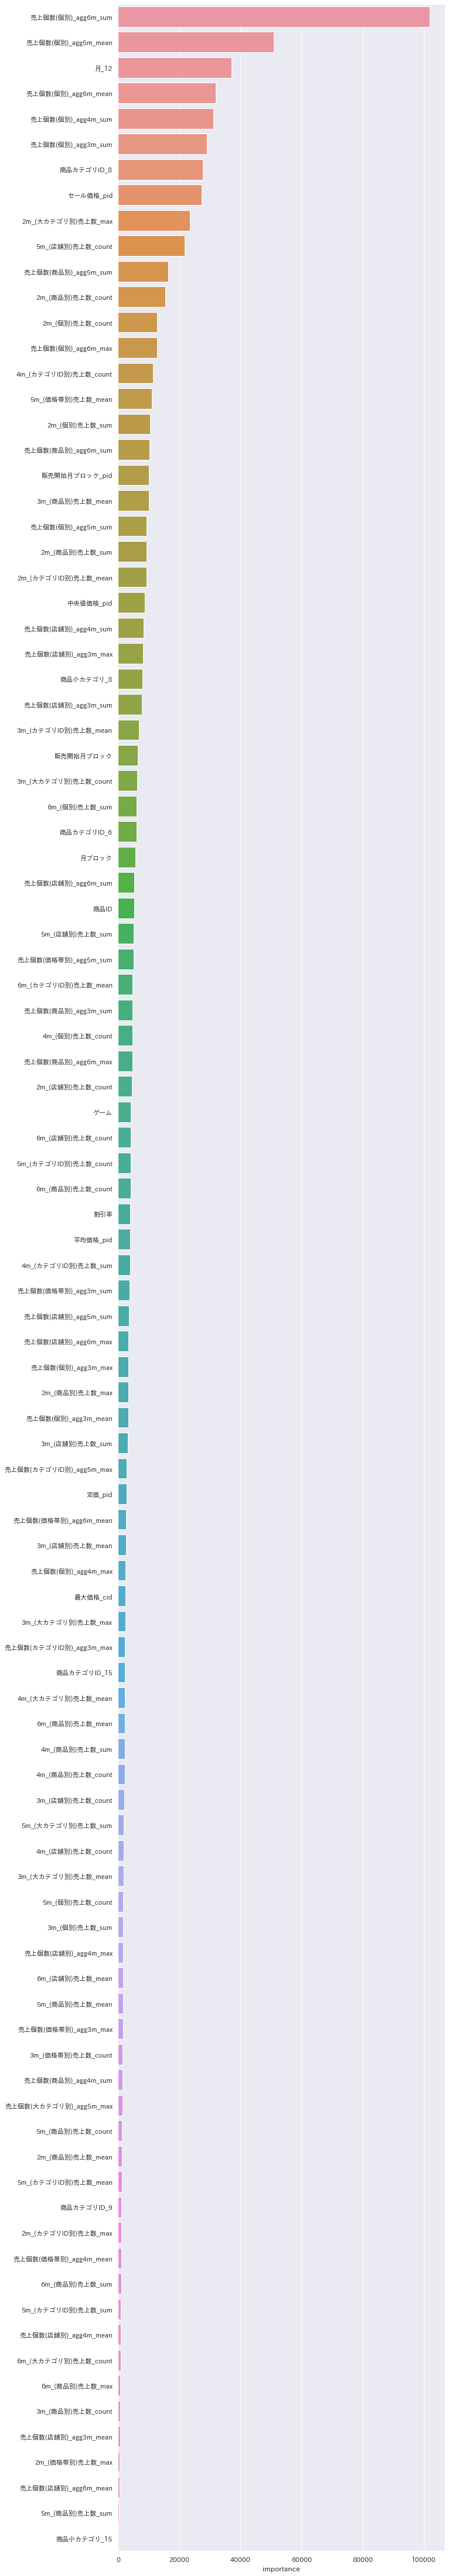

In [63]:
figure = plt.figure(figsize=(10, 80))
sns.set(font="IPAexGothic")
sns.barplot(x="importance", y=feature_importance.index, data=feature_importance)

In [64]:
use_col = feature_importance.index[:75]
y_pred,feature_importance = modeling(X_train[use_col],y_train,X_valid[use_col],y_valid,X_test[use_col],71)

[1]	training's l2: 2.862	training's rmse: 1.69174	valid_1's l2: 15.9418	valid_1's rmse: 3.99272
Training until validation scores don't improve for 20 rounds.
[2]	training's l2: 2.73164	training's rmse: 1.65277	valid_1's l2: 15.8212	valid_1's rmse: 3.97759
[3]	training's l2: 2.61145	training's rmse: 1.616	valid_1's l2: 15.7345	valid_1's rmse: 3.96668
[4]	training's l2: 2.50592	training's rmse: 1.58301	valid_1's l2: 15.6376	valid_1's rmse: 3.95444
[5]	training's l2: 2.40415	training's rmse: 1.55053	valid_1's l2: 15.5557	valid_1's rmse: 3.94407
[6]	training's l2: 2.30836	training's rmse: 1.51933	valid_1's l2: 15.4805	valid_1's rmse: 3.93452
[7]	training's l2: 2.22505	training's rmse: 1.49166	valid_1's l2: 15.4146	valid_1's rmse: 3.92614
[8]	training's l2: 2.14831	training's rmse: 1.46571	valid_1's l2: 15.3616	valid_1's rmse: 3.91939
[9]	training's l2: 2.07915	training's rmse: 1.44193	valid_1's l2: 15.2909	valid_1's rmse: 3.91035
[10]	training's l2: 2.01485	training's rmse: 1.41945	valid_1

### 検定無し

In [65]:
def train_test_split(dataset):
  train_dataset = dataset[(dataset['月ブロック'] >= 6) & (dataset['月ブロック'] < 21)]
  test_dataset = dataset[dataset['月ブロック'] == 23]

  X_train = train_dataset.drop('売上個数', axis=1)
  y_train = train_dataset['売上個数']
  X_test = test_dataset.drop(['売上個数'], axis=1)

  return X_train,y_train,X_test

In [66]:
X_train,y_train,X_test = train_test_split(dataset)

In [67]:
def modeling(X_train,y_train,X_test,seed):
  clf = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
                                importance_type='split', learning_rate=0.05, max_depth=-1,
                                min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
                                n_estimators=9999, n_jobs=-1, num_leaves=31, objective='regression',
                                random_state=seed, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                subsample=1.0, subsample_for_bin=200000, subsample_freq=0,)
  clf.fit(X_train, y_train,)

  feature_importance = pd.DataFrame(
                                    clf.booster_.feature_importance(importance_type='gain'), 
                                    index = X_train.columns, columns=['importance']).sort_values(['importance'], 
                                    ascending=False
                                    )

  y_pred = clf.predict(X_test)

  return y_pred,feature_importance

In [68]:
y_pred,feature_importance = modeling(X_train,y_train,X_test,71)

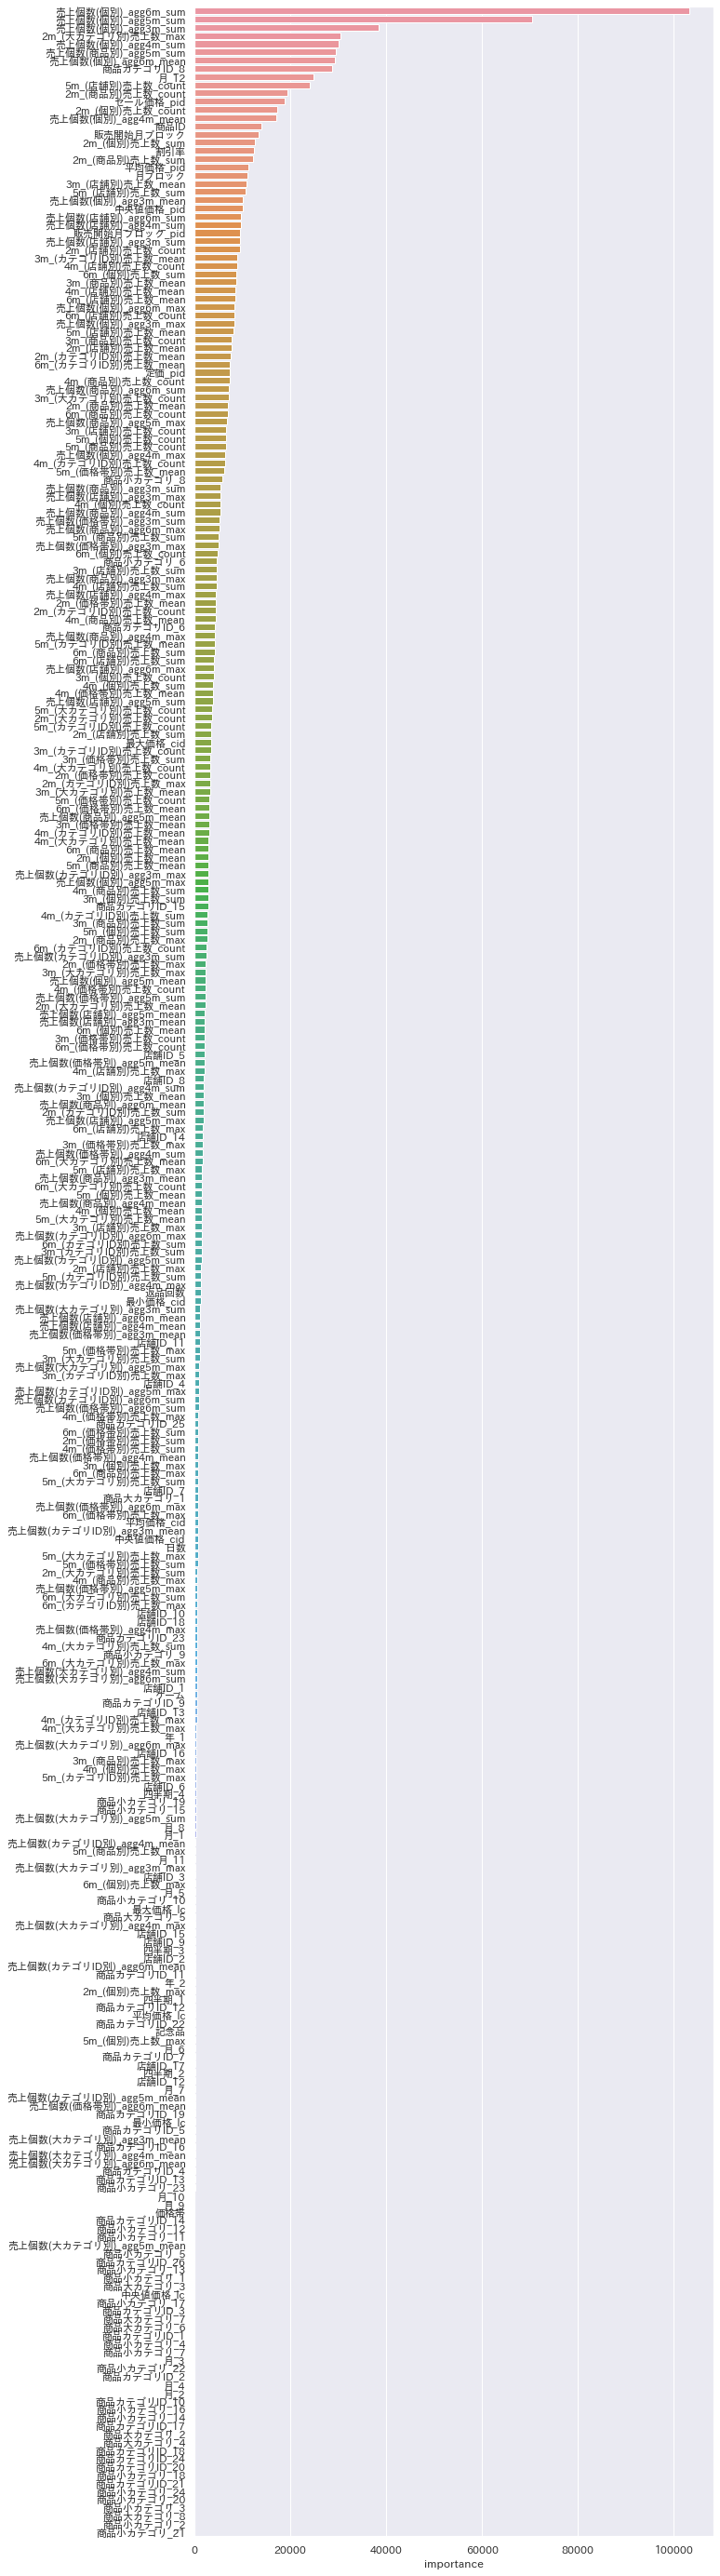

In [69]:
figure = plt.figure(figsize=(10, 50))
sns.set(font="IPAexGothic")
sns.barplot(x="importance", y=feature_importance.index, data=feature_importance)

In [70]:
test['y'] = y_pred
test.loc[test['y'] < 0 ,'y'] = 0

In [71]:
test.head()

,商品ID,店舗ID,月ブロック,y
index,,,,
0,1000001,0,23,1.93
1,1000001,1,23,0.90
2,1000001,2,23,2.66
3,1000001,3,23,6.34
4,1000001,4,23,11.41


# Submission

In [72]:
# sample_submissionの右側のカラムに予測値を代入する。
sub.iloc[:, -1] = test['y']
sub

,0,1
0,0,1.93
1,1,0.90
2,2,2.66
3,3,6.34
4,4,11.41
...,...,...
3055,3055,2.89
3056,3056,0.28
3057,3057,0.00
3058,3058,0.35


In [73]:
# 予測ファイルの生成
sub.to_csv('my_submission_20211001.csv', index=False, header=False)